In [1]:
!unzip '/content/drive/My Drive/Copy of Assignment 5 Dataset.zip' -d Assignment_5_Data

Streaming output truncated to the last 5000 lines.
  inflating: Assignment_5_Data/Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: Assignment_5_Data/Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: Assignment_5_Data/Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: Assignment_5_Data/Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: Assignment_5_Data/Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: Assignment_5_Data/Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: Assignment_5_Data/Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: Assignment_5_Data/Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: Assignment_5_Data/Assignment 5 Dataset/train/normal/7f11cf49-7b97-4d39-8

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
data_dir = '/content/Assignment_5_Data/Assignment 5 Dataset'

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
testloader = torch.utils.data.DataLoader(test_data, batch_size=30, shuffle=True)
print("Classes: ")
class_names = image_datasets['train'].classes
print(class_names)

Classes: 
['infected', 'normal']


#Loading the Vgg16 Model

In [93]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [94]:
print(vgg16.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


## Removing last layer

In [95]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-7] # Remove last layer
print(features)

[]


## Freezing the layers

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

## Adding new layers

In [0]:
features.extend([nn.Linear(25088, ((82*10)+100))])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(((82*10)+100), 2)])



In [98]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

`
```

## Loss fucntion and optimizer

In [0]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

## Training

In [0]:
def train_model(model, criterion, optimizer, num_epochs=25,plot_err = True):
    since = time.time()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    Train_loss=[]
    Valid_loss=[]
    train_accuracy=[]
    valid_accuracy=[]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == 'train':
              Train_loss.append(epoch_loss)
            else:
              Valid_loss.append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'validation':
              valid_accuracy.append(epoch_acc)
            else:
              train_accuracy.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best validation Acc: {:4f}'.format(best_acc))
    if plot_err:
            plt.figure()
            plt.plot(Train_loss,color='r',label="Train")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.figure()
            plt.plot(Valid_loss,color='b',label="Valid")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.figure()
            plt.plot(train_accuracy,color='r',label="Train")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.figure()
            plt.plot(valid_accuracy,color='k',label="Valid")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.legend()
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model
    # model=model.cuda()

Epoch 0/9
----------
train Loss: 0.3376 Acc: 0.8683
validation Loss: 0.3421 Acc: 0.8813

Epoch 1/9
----------
train Loss: 0.3314 Acc: 0.8737
validation Loss: 0.3421 Acc: 0.8813

Epoch 2/9
----------
train Loss: 0.3276 Acc: 0.8722
validation Loss: 0.3421 Acc: 0.8813

Epoch 3/9
----------
train Loss: 0.3338 Acc: 0.8698
validation Loss: 0.3421 Acc: 0.8813

Epoch 4/9
----------
train Loss: 0.3254 Acc: 0.8747
validation Loss: 0.3421 Acc: 0.8813

Epoch 5/9
----------
train Loss: 0.3290 Acc: 0.8701
validation Loss: 0.3421 Acc: 0.8813

Epoch 6/9
----------
train Loss: 0.3162 Acc: 0.8775
validation Loss: 0.3421 Acc: 0.8813

Epoch 7/9
----------
train Loss: 0.3387 Acc: 0.8698
validation Loss: 0.3421 Acc: 0.8813

Epoch 8/9
----------
train Loss: 0.3278 Acc: 0.8705
validation Loss: 0.3421 Acc: 0.8813

Epoch 9/9
----------
train Loss: 0.3345 Acc: 0.8693
validation Loss: 0.3421 Acc: 0.8813

Training complete in 15m 46s
Best validation Acc: 0.881333


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

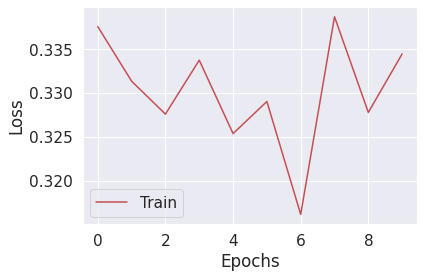

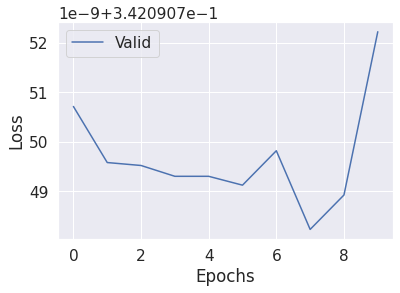

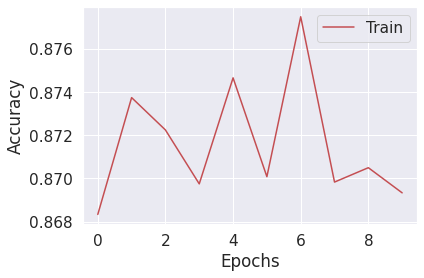

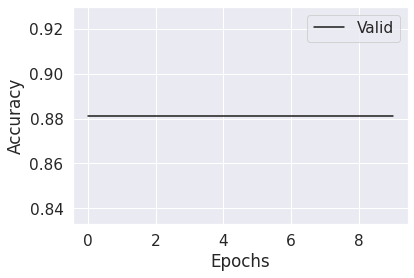

In [114]:
train_model(vgg16, criterion, optimizer, num_epochs=10)

In [0]:
 torch.save(vgg16.state_dict(), 'vgg16_fc_Only.pth')

In [0]:
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(confusion,classes=None, title='Confusion matrix', cmap=plt.cm.gray_r):
    ##X-axis is predicted and y_asix is true
    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    if classes is not None:
      df_cm = pd.DataFrame(confusion, classes, classes)
    else :
      df_cm = pd.DataFrame(confusion, range(len(confusion)), range(len(confusion)))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.title("Confusion Matrix")

    plt.savefig("confusion_matrix")
    plt.show()

In [0]:
classes = ['infected', 'normal']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def predict(model,dataloader,device):
  model.to(device)
  model.eval()
  num_elements = len(dataloader.dataset)
  predictions = torch.zeros(num_elements)
  all_labels = torch.zeros(num_elements)
  num_batches = len(dataloader)
  batch_size = dataloader.batch_size

  with torch.no_grad():
    for i,data in enumerate(dataloader):
      start = i*batch_size
      end = start + batch_size
      if i == num_batches - 1:
          end = num_elements

      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)
      outputs = model(inputs)
      _, pred = torch.max(outputs.data, 1)
      # _, predicted = torch.max(outputs.data, 1)
      predictions[start:end] = pred
      all_labels[start:end] = labels
  return all_labels.cpu().data.numpy(),predictions.cpu().data.numpy()


accuracy of resnet18_fc_cv_some 0.944
F1 score of resnet18_fc_cv_some 0.9531772575250834


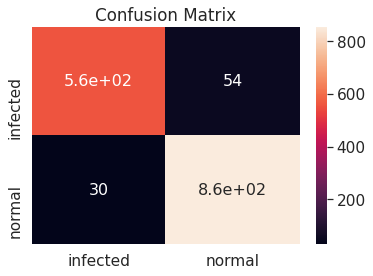

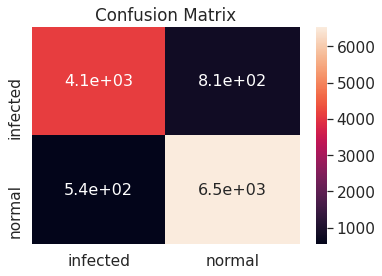

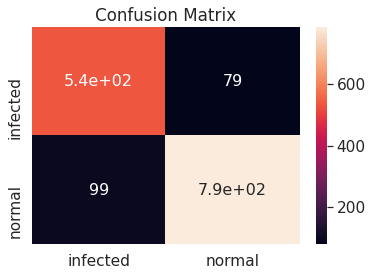

In [115]:
labels,preds = predict(vgg16,testloader,device) ###Predictions
labels_1,preds_1 = predict(vgg16,dataloaders['train'],device)
labels_2,preds_2 = predict(vgg16,dataloaders['validation'],device)
acc = accuracy_score(labels,preds)  ##labels and preds both are numpy array of shape (No.of examples,)
print('accuracy of resnet18_fc_cv_some',acc)
f1 = f1_score(labels,preds)
print('F1 score of resnet18_fc_cv_some',f1)
C = confusion_matrix(labels,preds)
plot_confusion_matrix(C,classes=classes)
a = confusion_matrix(labels_1,preds_1)
plot_confusion_matrix(a,classes=classes)
b = confusion_matrix(labels_2,preds_2)
plot_confusion_matrix(b,classes=classes)

## Resnet18 Model


In [104]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [105]:
print(resnet18.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [106]:
num_features = resnet18.fc.in_features
features = list(resnet18.fc.children())[:-1] # Remove last layer
print(features)

[]


In [0]:
# Freeze training for all layers
for param in resnet18.parameters():
    param.requires_grad = False

In [0]:
features.extend([nn.Linear(512, ((82*10)+100))])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(((82*10)+100), 2)])


In [109]:
 resnet18.fc= nn.Sequential(*features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

Epoch 0/9
----------
train Loss: 0.5277 Acc: 0.7472
validation Loss: 0.3672 Acc: 0.8340

Epoch 1/9
----------
train Loss: 0.4818 Acc: 0.7839
validation Loss: 0.3633 Acc: 0.8553

Epoch 2/9
----------
train Loss: 0.4819 Acc: 0.7792
validation Loss: 0.4030 Acc: 0.8367

Epoch 3/9
----------
train Loss: 0.4653 Acc: 0.7903
validation Loss: 0.3974 Acc: 0.8473

Epoch 4/9
----------
train Loss: 0.4665 Acc: 0.7875
validation Loss: 0.3696 Acc: 0.8467

Epoch 5/9
----------
train Loss: 0.4660 Acc: 0.7865
validation Loss: 0.3686 Acc: 0.8507

Epoch 6/9
----------
train Loss: 0.4587 Acc: 0.7893
validation Loss: 0.3568 Acc: 0.8460

Epoch 7/9
----------
train Loss: 0.4614 Acc: 0.7890
validation Loss: 0.3535 Acc: 0.8467

Epoch 8/9
----------
train Loss: 0.4610 Acc: 0.7908
validation Loss: 0.3826 Acc: 0.8087

Epoch 9/9
----------
train Loss: 0.4539 Acc: 0.7971
validation Loss: 0.3490 Acc: 0.8533

Training complete in 15m 34s
Best validation Acc: 0.855333


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

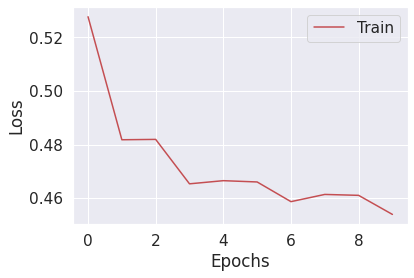

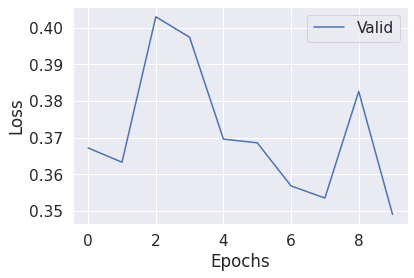

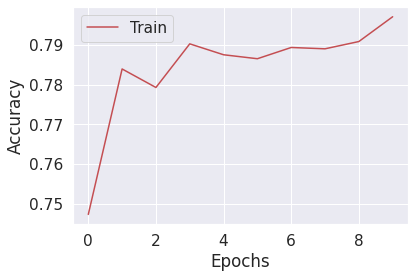

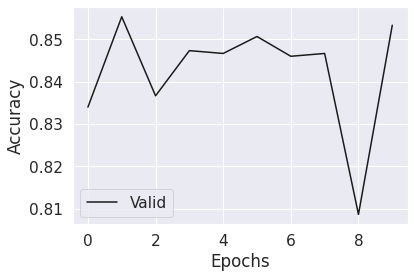

In [111]:
train_model(resnet18, criterion, optimizer, num_epochs=10)

accuracy of resnet18_fc_cv_some 0.9186666666666666
F1 score of resnet18_fc_cv_some 0.9311512415349886


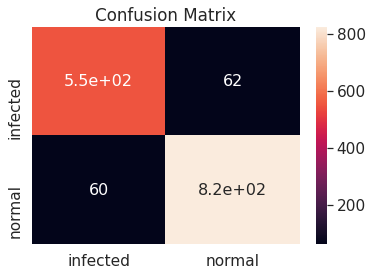

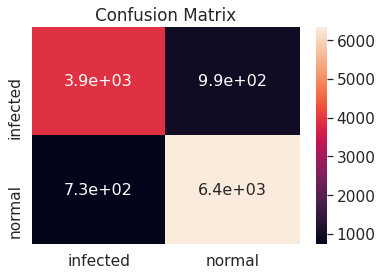

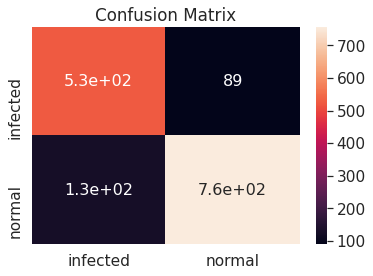

In [112]:
labels,preds = predict(resnet18,testloader,device) ###Predictions
labels_1,preds_1 = predict(resnet18,dataloaders['train'],device)
labels_2,preds_2 = predict(resnet18,dataloaders['validation'],device)
acc = accuracy_score(labels,preds)  ##labels and preds both are numpy array of shape (No.of examples,)
print('accuracy of resnet18_fc_cv_some',acc)
f1 = f1_score(labels,preds)
print('F1 score of resnet18_fc_cv_some',f1)
C = confusion_matrix(labels,preds)
plot_confusion_matrix(C,classes=classes)
a = confusion_matrix(labels_1,preds_1)
plot_confusion_matrix(a,classes=classes)
b = confusion_matrix(labels_2,preds_2)
plot_confusion_matrix(b,classes=classes)

In [0]:
 torch.save(resnet18.state_dict(), 'resnet18_fc_Only.pth')

## Task 2

## vgg16 Model With some layers unfreeze

```
# This is formatted as code
```



In [27]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-7] # Remove last layer
print(features)

[]


In [0]:
# Freeze training for all layers
for param in vgg16.features[:-5].parameters():
    param.require_grad = False

In [0]:
features.extend([nn.Linear(25088, ((82*10)+100))])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(((82*10)+100), 2)])

In [31]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Epoch 0/9
----------
train Loss: 0.3552 Acc: 0.8527
validation Loss: 0.2315 Acc: 0.9053

Epoch 1/9
----------
train Loss: 0.2747 Acc: 0.8923
validation Loss: 0.2277 Acc: 0.9000

Epoch 2/9
----------
train Loss: 0.2537 Acc: 0.9024
validation Loss: 0.2416 Acc: 0.8980

Epoch 3/9
----------
train Loss: 0.2357 Acc: 0.9092
validation Loss: 0.2633 Acc: 0.8893

Epoch 4/9
----------
train Loss: 0.2242 Acc: 0.9173
validation Loss: 0.2475 Acc: 0.8953

Epoch 5/9
----------
train Loss: 0.2203 Acc: 0.9180
validation Loss: 0.2154 Acc: 0.9147

Epoch 6/9
----------
train Loss: 0.2122 Acc: 0.9206
validation Loss: 0.2247 Acc: 0.9087

Epoch 7/9
----------
train Loss: 0.2137 Acc: 0.9196
validation Loss: 0.2099 Acc: 0.9140

Epoch 8/9
----------
train Loss: 0.1976 Acc: 0.9239
validation Loss: 0.2390 Acc: 0.9040

Epoch 9/9
----------
train Loss: 0.2024 Acc: 0.9246
validation Loss: 0.2338 Acc: 0.9133

Training complete in 24m 43s
Best validation Acc: 0.914667


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

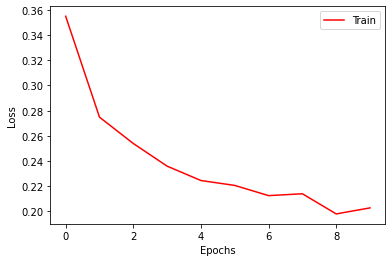

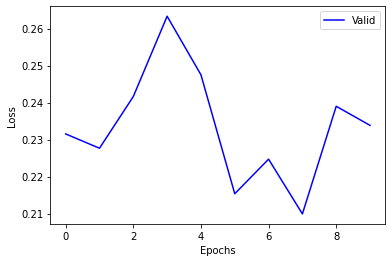

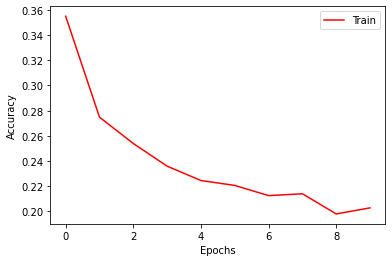

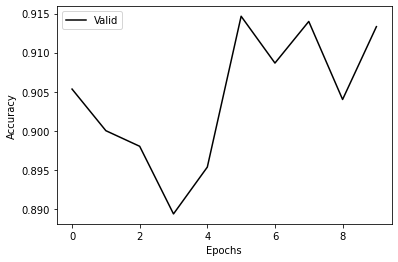

In [33]:
train_model(vgg16, criterion, optimizer, num_epochs=10)

accuracy of vgg16_fc_cv_some 0.9713333333333334
F1 score of vgg16_fc_cv_some 0.9760178471834913


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


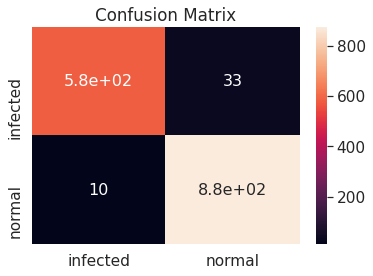

In [34]:
## VGG - Train confusion Matrix
labels,preds = predict(vgg16,testloader,device) ###Predictions


acc = accuracy_score(labels,preds)  ##labels and preds both are numpy array of shape (No.of examples,)
print('accuracy of vgg16_fc_cv_some',acc)
f1 = f1_score(labels,preds)
print('F1 score of vgg16_fc_cv_some',f1)
C = confusion_matrix(labels,preds)
plot_confusion_matrix(C,classes=classes)

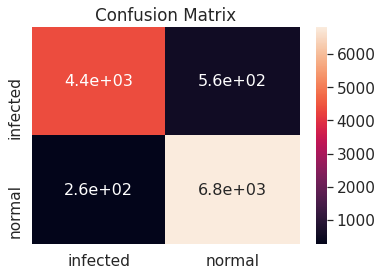

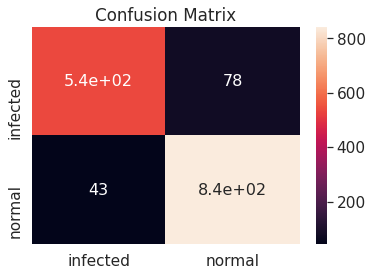

In [90]:
labels_1,preds_1 = predict(vgg16,dataloaders['train'],device)
labels_2,preds_2 = predict(vgg16,dataloaders['validation'],device)
a = confusion_matrix(labels_1,preds_1)
plot_confusion_matrix(a,classes=classes)
b = confusion_matrix(labels_2,preds_2)
plot_confusion_matrix(b,classes=classes)

Resnet18 Model

In [69]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [70]:
print(resnet18.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [71]:
num_features = resnet18.fc.in_features
features = list(resnet18.fc.children())[:-1] # Remove last layer
print(features)

[]


In [0]:
# Freeze training for all layers
for param in resnet18.layer3.parameters():
    param.requires_grad = False


In [0]:
features.extend([nn.Linear(512, ((82*10)+100))])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(((82*10)+100), 2)])


In [74]:
 resnet18.fc= nn.Sequential(*features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

Epoch 0/9
----------
train Loss: 0.5618 Acc: 0.7384
validation Loss: 0.4182 Acc: 0.8000

Epoch 1/9
----------
train Loss: 0.4927 Acc: 0.7831
validation Loss: 0.3942 Acc: 0.8260

Epoch 2/9
----------
train Loss: 0.4470 Acc: 0.8087
validation Loss: 0.3464 Acc: 0.8433

Epoch 3/9
----------
train Loss: 0.4090 Acc: 0.8323
validation Loss: 0.3524 Acc: 0.8627

Epoch 4/9
----------
train Loss: 0.3825 Acc: 0.8448
validation Loss: 0.3149 Acc: 0.8740

Epoch 5/9
----------
train Loss: 0.3560 Acc: 0.8585
validation Loss: 0.2840 Acc: 0.8807

Epoch 6/9
----------
train Loss: 0.3242 Acc: 0.8713
validation Loss: 0.2759 Acc: 0.8960

Epoch 7/9
----------
train Loss: 0.3112 Acc: 0.8787
validation Loss: 0.2793 Acc: 0.8967

Epoch 8/9
----------
train Loss: 0.3033 Acc: 0.8801
validation Loss: 0.2621 Acc: 0.8980

Epoch 9/9
----------
train Loss: 0.2838 Acc: 0.8870
validation Loss: 0.2588 Acc: 0.8993

Training complete in 19m 29s
Best validation Acc: 0.899333


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

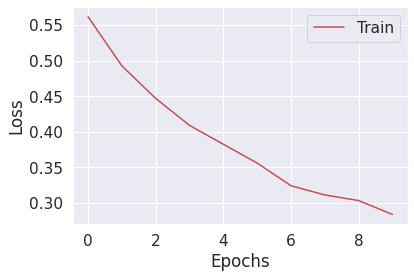

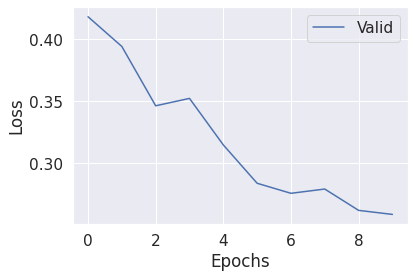

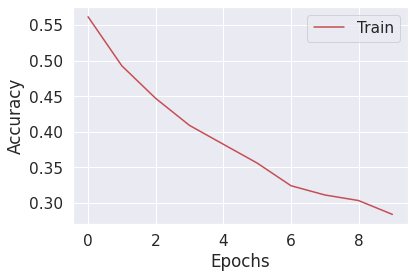

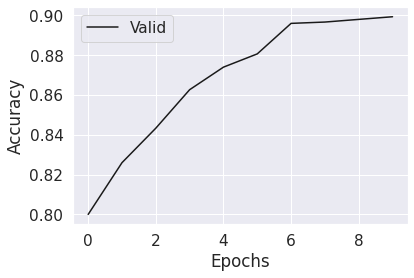

In [76]:
train_model(resnet18, criterion, optimizer, num_epochs=10)

accuracy of resnet18_fc_cv_some 0.9633333333333334
F1 score of resnet18_fc_cv_some 0.9693251533742332


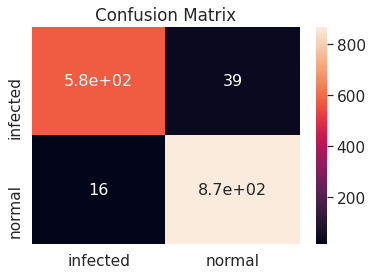

In [77]:
labels,preds = predict(resnet18,testloader,device) ###Predictions


acc = accuracy_score(labels,preds)  ##labels and preds both are numpy array of shape (No.of examples,)
print('accuracy of resnet18_fc_cv_some',acc)
f1 = f1_score(labels,preds)
print('F1 score of resnet18_fc_cv_some',f1)
C = confusion_matrix(labels,preds)
plot_confusion_matrix(C,classes=classes)

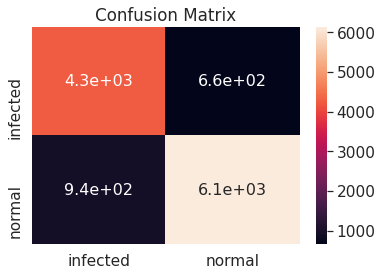

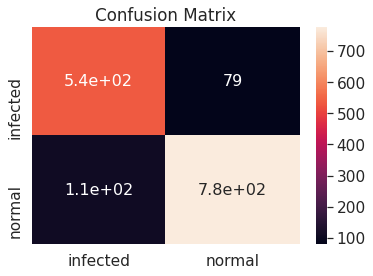

In [89]:

labels_1,preds_1 = predict(resnet18,dataloaders['train'],device)
labels_2,preds_2 = predict(resnet18,dataloaders['validation'],device)
a = confusion_matrix(labels_1,preds_1)
plot_confusion_matrix(a,classes=classes)
b = confusion_matrix(labels_2,preds_2)
plot_confusion_matrix(b,classes=classes)

## Vgg16_entire Model 

In [39]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [40]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-7] # Remove last layer
print(features)

[]


In [0]:
features.extend([nn.Linear(25088, ((82*10)+100))])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(((82*10)+100), 2)])

In [42]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Epoch 0/9
----------
train Loss: 0.3455 Acc: 0.8584
validation Loss: 0.2606 Acc: 0.8987

Epoch 1/9
----------
train Loss: 0.2709 Acc: 0.8939
validation Loss: 0.2679 Acc: 0.8787

Epoch 2/9
----------
train Loss: 0.2558 Acc: 0.9034
validation Loss: 0.2462 Acc: 0.9007

Epoch 3/9
----------
train Loss: 0.2353 Acc: 0.9120
validation Loss: 0.2267 Acc: 0.9120

Epoch 4/9
----------
train Loss: 0.2283 Acc: 0.9114
validation Loss: 0.2324 Acc: 0.9100

Epoch 5/9
----------
train Loss: 0.2158 Acc: 0.9197
validation Loss: 0.2220 Acc: 0.9113

Epoch 6/9
----------
train Loss: 0.2052 Acc: 0.9229
validation Loss: 0.2349 Acc: 0.9107

Epoch 7/9
----------
train Loss: 0.2042 Acc: 0.9232
validation Loss: 0.2060 Acc: 0.9193

Epoch 8/9
----------
train Loss: 0.2039 Acc: 0.9211
validation Loss: 0.2216 Acc: 0.9127

Epoch 9/9
----------
train Loss: 0.2008 Acc: 0.9231
validation Loss: 0.2286 Acc: 0.9173

Training complete in 25m 4s
Best validation Acc: 0.919333


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

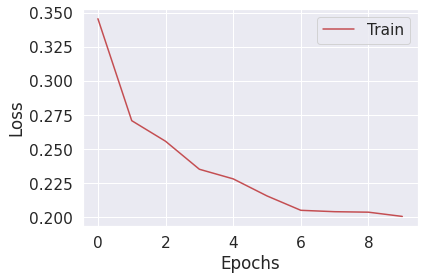

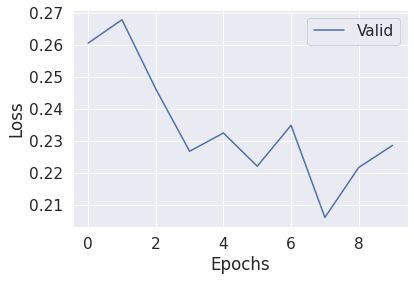

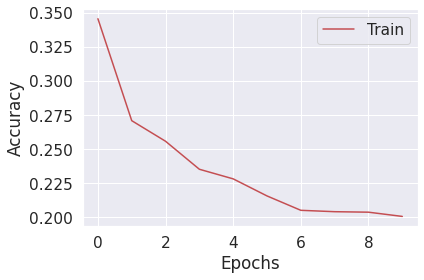

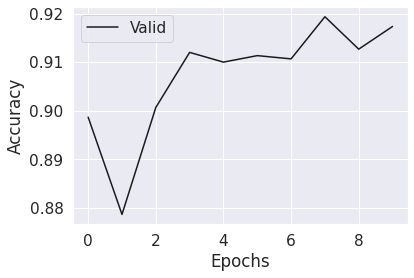

In [44]:
train_model(vgg16, criterion, optimizer, num_epochs=10)

accuracy of resnet18_fc_cv_some 0.9733333333333334
F1 score of resnet18_fc_cv_some 0.9776035834266518


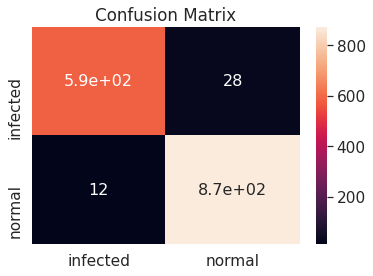

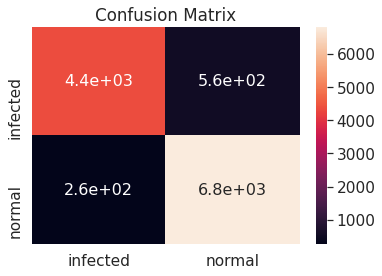

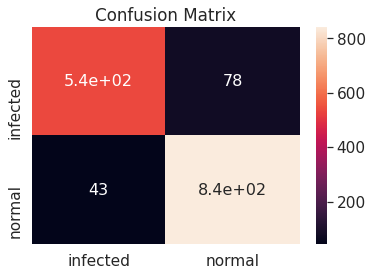

In [88]:
labels,preds = predict(vgg16,testloader,device) ###Predictions
labels_1,preds_1 = predict(vgg16,dataloaders['train'],device)
labels_2,preds_2 = predict(vgg16,dataloaders['validation'],device)
acc = accuracy_score(labels,preds)  ##labels and preds both are numpy array of shape (No.of examples,)
print('accuracy of resnet18_fc_cv_some',acc)
f1 = f1_score(labels,preds)
print('F1 score of resnet18_fc_cv_some',f1)
C = confusion_matrix(labels,preds)
plot_confusion_matrix(C,classes=classes)
a = confusion_matrix(labels_1,preds_1)
plot_confusion_matrix(a,classes=classes)
b = confusion_matrix(labels_2,preds_2)
plot_confusion_matrix(b,classes=classes)

In [0]:
 torch.save(vgg16.state_dict(), 'vgg16_entire.pth')

## Resnet18_entire Model

In [78]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [79]:
num_features = resnet18.fc.in_features
features = list(resnet18.fc.children())[:-1] # Remove last layer
print(features)

[]


In [0]:
features.extend([nn.Linear(512, ((82*10)+100))])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(((82*10)+100), 2)])

In [81]:
resnet18.fc= nn.Sequential(*features)
print(resnet18)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

Epoch 0/9
----------
train Loss: 0.6028 Acc: 0.7025
validation Loss: 0.6738 Acc: 0.7533

Epoch 1/9
----------
train Loss: 0.5515 Acc: 0.7397
validation Loss: 0.4271 Acc: 0.8160

Epoch 2/9
----------
train Loss: 0.5190 Acc: 0.7659
validation Loss: 0.5135 Acc: 0.7880

Epoch 3/9
----------
train Loss: 0.4904 Acc: 0.7812
validation Loss: 0.4182 Acc: 0.8120

Epoch 4/9
----------
train Loss: 0.4648 Acc: 0.7985
validation Loss: 0.3893 Acc: 0.8460

Epoch 5/9
----------
train Loss: 0.4361 Acc: 0.8107
validation Loss: 0.4014 Acc: 0.8287

Epoch 6/9
----------
train Loss: 0.4106 Acc: 0.8300
validation Loss: 0.3387 Acc: 0.8553

Epoch 7/9
----------
train Loss: 0.3811 Acc: 0.8431
validation Loss: 0.3933 Acc: 0.8433

Epoch 8/9
----------
train Loss: 0.3620 Acc: 0.8504
validation Loss: 0.4010 Acc: 0.8447

Epoch 9/9
----------
train Loss: 0.3522 Acc: 0.8588
validation Loss: 0.3059 Acc: 0.8760

Training complete in 21m 24s
Best validation Acc: 0.876000


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

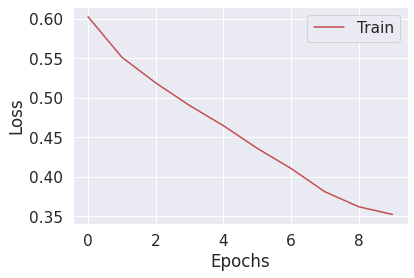

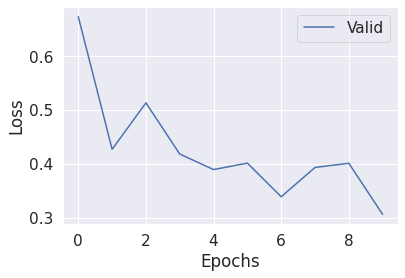

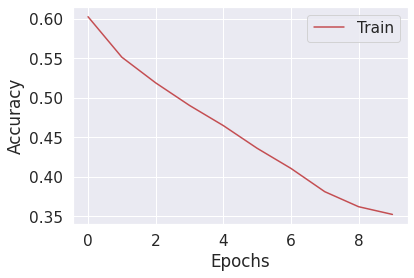

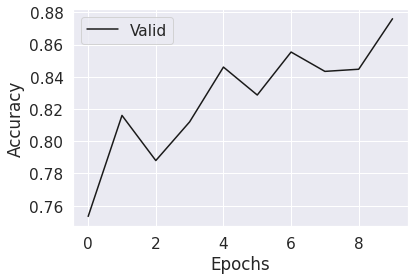

In [83]:
train_model(resnet18, criterion, optimizer, num_epochs=10)

accuracy of resnet18_fc_cv_some 0.9346666666666666
F1 score of resnet18_fc_cv_some 0.944127708095781


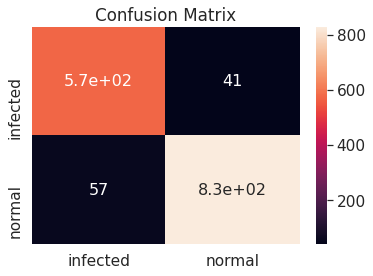

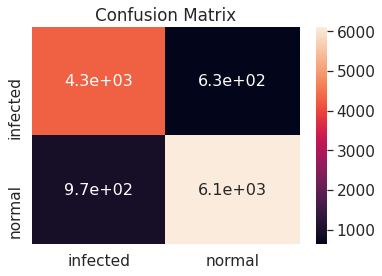

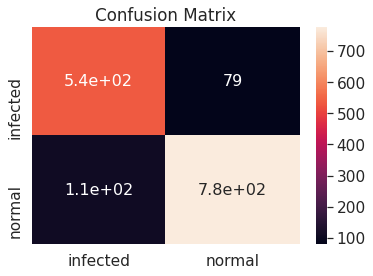

In [86]:
labels,preds = predict(resnet18,testloader,device) ###Predictions
labels_1,preds_1 = predict(resnet18,dataloaders['train'],device)
labels_2,preds_2 = predict(resnet18,dataloaders['validation'],device)
acc = accuracy_score(labels,preds)  ##labels and preds both are numpy array of shape (No.of examples,)
print('accuracy of resnet18_fc_cv_some',acc)
f1 = f1_score(labels,preds)
print('F1 score of resnet18_fc_cv_some',f1)
C = confusion_matrix(labels,preds)
plot_confusion_matrix(C,classes=classes)
a = confusion_matrix(labels_1,preds_1)
plot_confusion_matrix(a,classes=classes)
b = confusion_matrix(labels_2,preds_2)
plot_confusion_matrix(b,classes=classes)

In [0]:
 torch.save(resnet18.state_dict(), 'resnet18_entire.pth')